<a href="https://colab.research.google.com/github/Gratisfo/Parentents-and-children/blob/main/topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('data_TM.csv')

# Preprocessing

In [ ]:
! pip install natasha

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2[fast]

In [7]:
from natasha import (
    Segmenter,
    MorphVocab,
    Doc,
    DatesExtractor,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

In [ ]:
import re
import pymorphy2
import nltk
from razdel import sentenize, tokenize
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()

In [9]:
def del_ner(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_ner(ner_tagger)
  list_ner = []
   
  # create ner list 
  for i, elem in enumerate(doc.spans):
      list_ner.append((list(doc.spans[i]))[3])

  # del ner
  for i in list_ner:
      if i in text:
          text = text.replace(i, '') 
  return text

In [10]:
def preproc_text(text):

  # delete ner
  text = del_ner(text) 

  # tokenize
  tokens = [_.text for _ in list(tokenize(text))]
  
  # lower register
  tokens = [w.lower() for w in tokens]
  
  # remove puntuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  
  # remove numbers, save only letters
  words = [word for word in stripped if word.isalpha()]
  
  # to normal form
  # save only nouns
  words = [morph.parse(w)[0].normal_form for w in words if morph.parse(w)[0].tag.POS == "NOUN"] 

  # delete stop-words
  stop_words = stopwords.words('russian')
  stop_words = stop_words + ['мой', 'тая', 'твой', 'ваш', 'всетаки', 'свой', 'делатьто', 'такой', 'какой', 'наш', 'который']
  words = [w for w in words if w not in stop_words]
  
  return words

In [11]:
data['clean_text'] = data['text'].apply(lambda x: preproc_text(x)) 

# Topic Modeling

In [ ]:
!pip install pyLDAvis

In [ ]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [14]:
def builg_ngrams(data_words):
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  return bigram_mod, trigram_mod

def make_bigrams(texts):
    bigram_mod, trigram_mod = builg_ngrams(texts)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram_mod, trigram_mod = builg_ngrams(texts)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def topic_modeling(words):
    bigram, trigram = builg_ngrams(words)
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]
    return corpus, id2word

#LDA model gensim

In [15]:
corpus, id2word = topic_modeling(data.clean_text.values)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,   #изменить - уменьшить
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [49]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"друг" + 0.033*"любовь" + 0.027*"жизнь" + 0.027*"день" + '
  '0.022*"дедушка" + 0.018*"слово" + 0.016*"право" + 0.013*"рука" + '
  '0.012*"чувство" + 0.011*"мужик"'),
 (1,
  '0.040*"отец" + 0.038*"бог" + 0.031*"душа" + 0.026*"брат" + 0.022*"девка" + '
  '0.019*"сын" + 0.017*"мать" + 0.015*"свет" + 0.013*"беда" + 0.013*"господь"'),
 (2,
  '0.042*"дочь" + 0.037*"сердце" + 0.026*"счастие" + 0.025*"чай" + '
  '0.024*"смерть" + 0.024*"честь" + 0.019*"родитель" + 0.016*"мысль" + '
  '0.014*"барин" + 0.013*"судьба"'),
 (3,
  '0.060*"человек" + 0.037*"муж" + 0.032*"батюшка" + 0.029*"жена" + '
  '0.028*"матушка" + 0.025*"женщина" + 0.024*"ум" + 0.017*"сударыня" + '
  '0.016*"дурак" + 0.014*"сударь"'),
 (4,
  '0.089*"дело" + 0.054*"деньга" + 0.029*"дом" + 0.027*"человек" + 0.020*"бог" '
  '+ 0.017*"грех" + 0.013*"баба" + 0.012*"голова" + 0.012*"рука" + '
  '0.012*"ягодка"'),
 (5,
  '0.062*"маменька" + 0.023*"превосходительство" + 0.015*"папа" + '
  '0.011*"тётка" + 0.010*"дядя" + 0

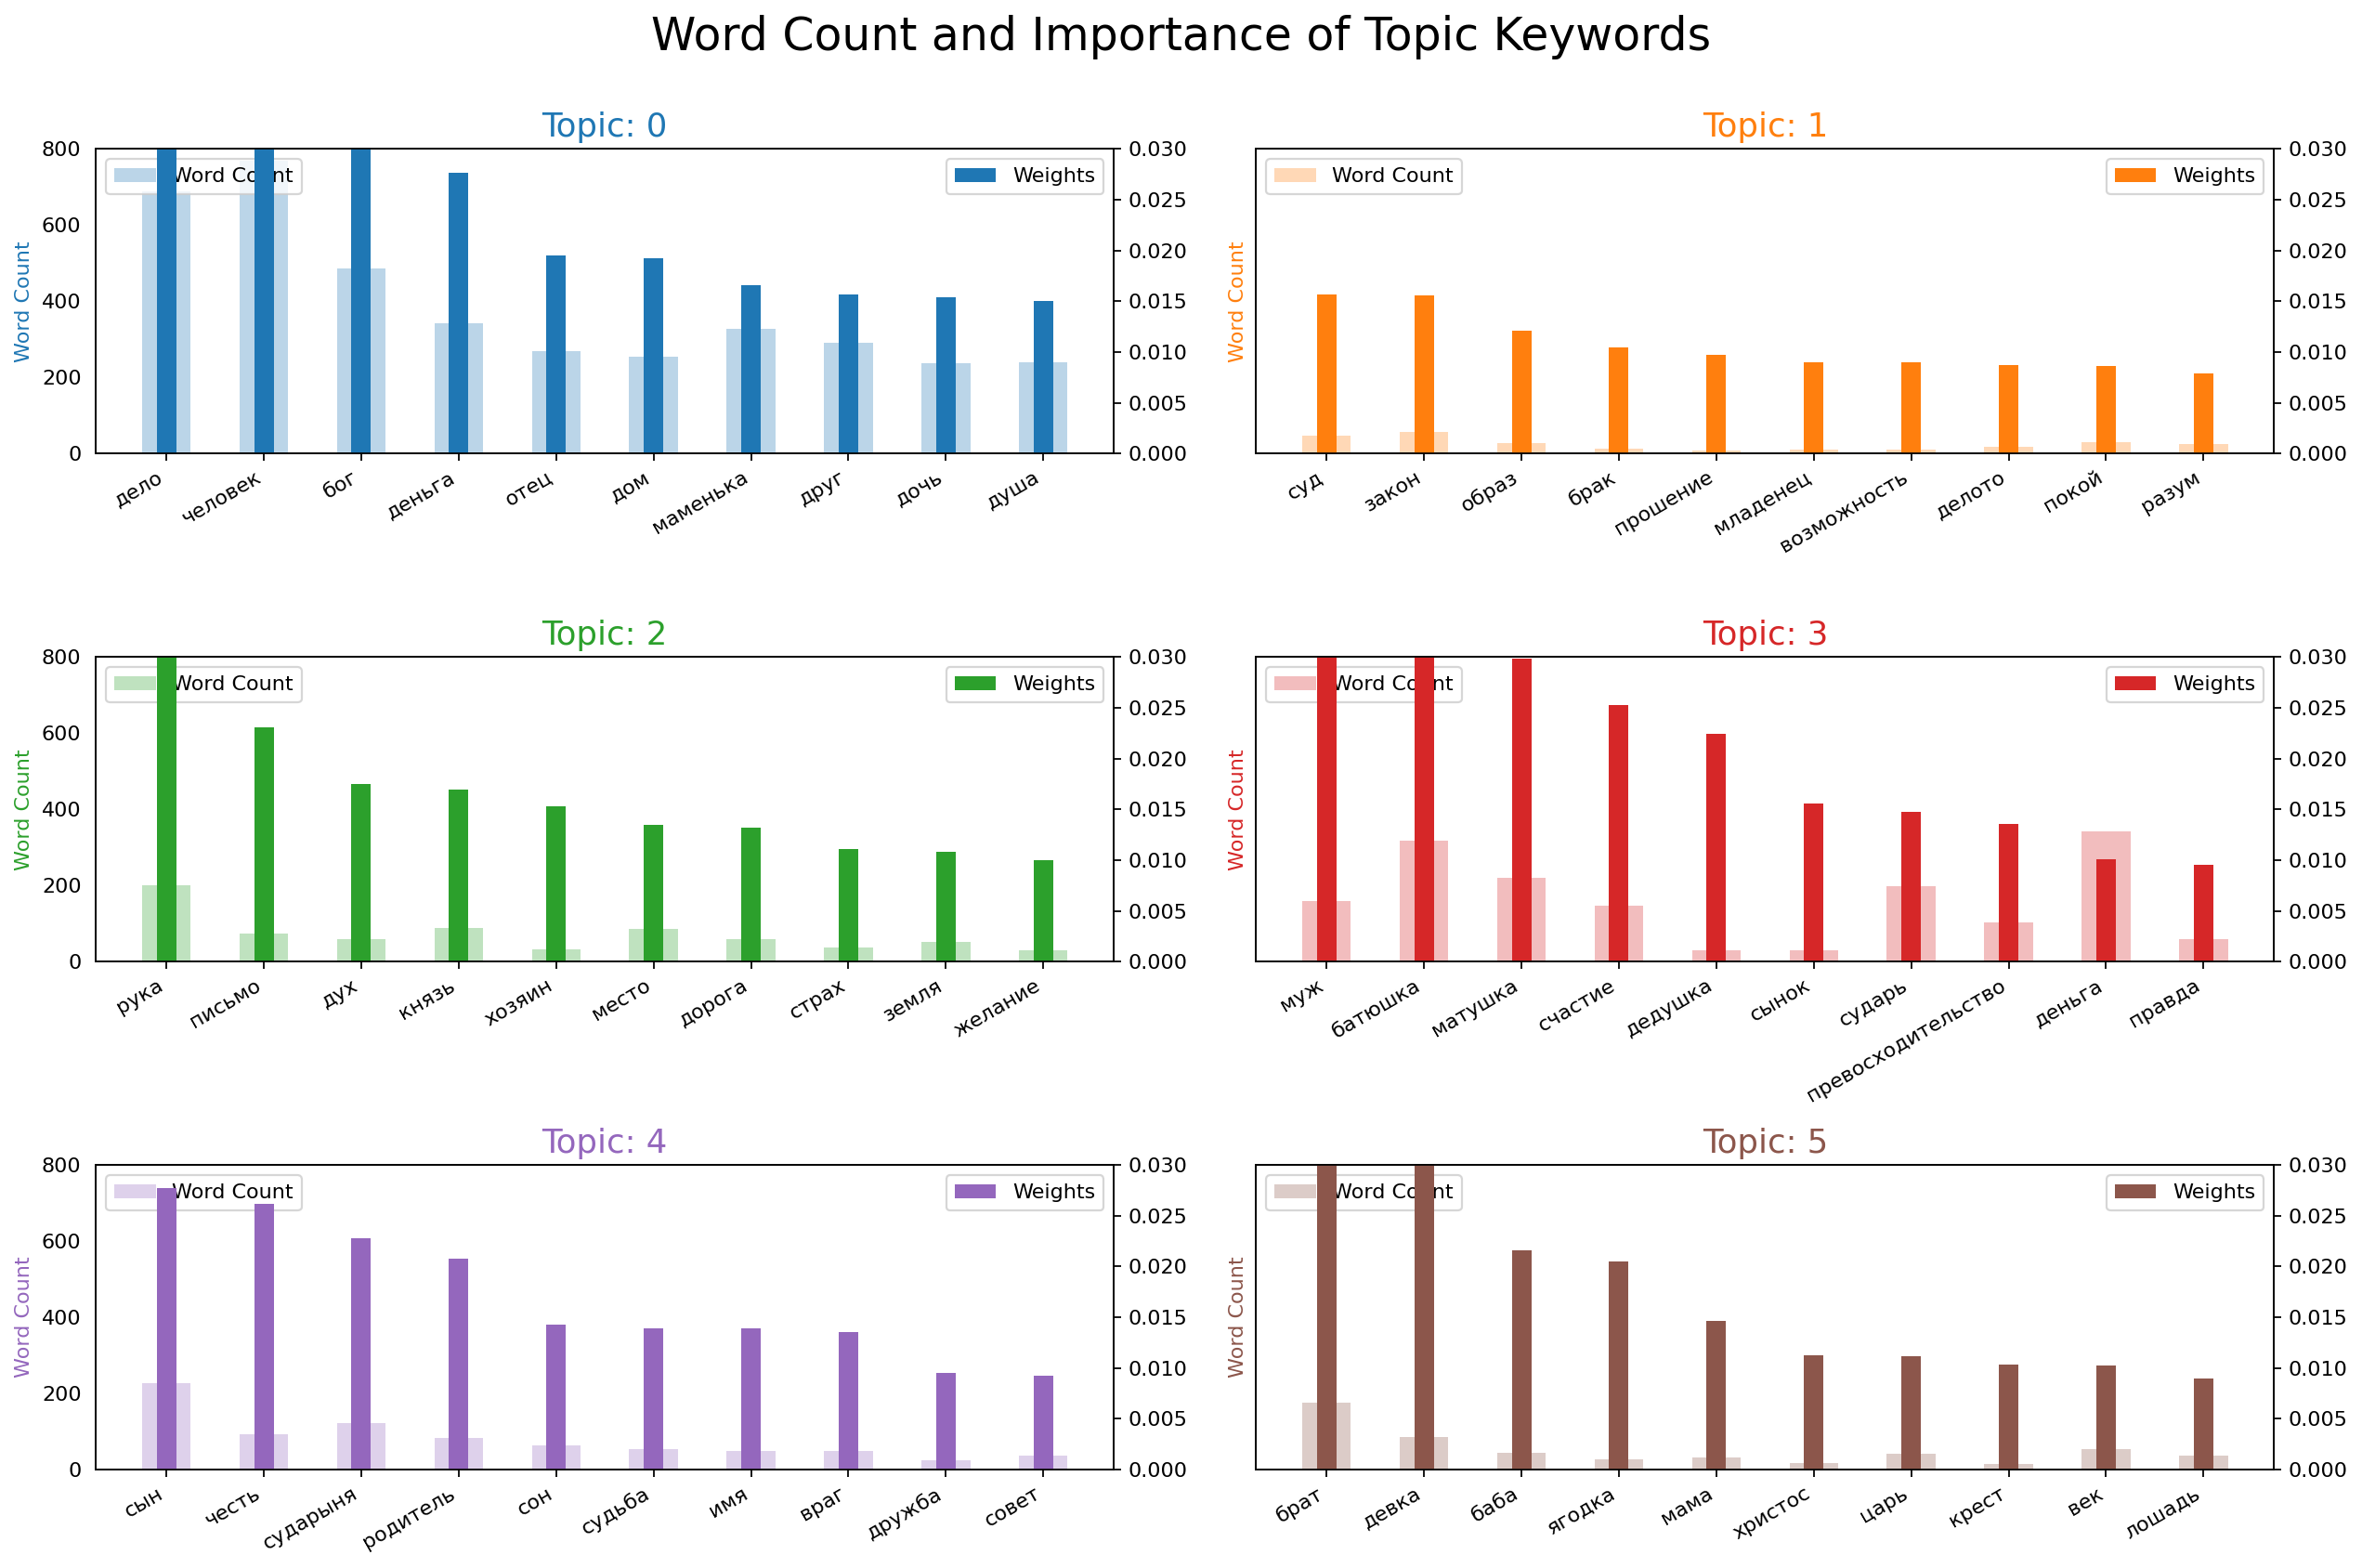

In [59]:
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data.clean_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 800)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Try different parameters

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=50,   #изменить - уменьшить
                                           passes=6,
                                           alpha='auto',
                                           per_word_topics=True)


In [52]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"дело" + 0.046*"человек" + 0.030*"бог" + 0.028*"деньга" + '
  '0.020*"отец" + 0.019*"дом" + 0.017*"маменька" + 0.016*"друг" + 0.015*"дочь" '
  '+ 0.015*"душа"'),
 (1,
  '0.016*"суд" + 0.016*"закон" + 0.012*"образ" + 0.010*"брак" + '
  '0.010*"прошение" + 0.009*"младенец" + 0.009*"возможность" + 0.009*"делото" '
  '+ 0.009*"покой" + 0.008*"разум"'),
 (2,
  '0.043*"рука" + 0.023*"письмо" + 0.017*"дух" + 0.017*"князь" + '
  '0.015*"хозяин" + 0.014*"место" + 0.013*"дорога" + 0.011*"страх" + '
  '0.011*"земля" + 0.010*"желание"'),
 (3,
  '0.039*"муж" + 0.033*"батюшка" + 0.030*"матушка" + 0.025*"счастие" + '
  '0.022*"дедушка" + 0.016*"сынок" + 0.015*"сударь" + '
  '0.014*"превосходительство" + 0.010*"деньга" + 0.010*"правда"'),
 (4,
  '0.028*"сын" + 0.026*"честь" + 0.023*"сударыня" + 0.021*"родитель" + '
  '0.014*"сон" + 0.014*"судьба" + 0.014*"имя" + 0.014*"враг" + 0.010*"дружба" '
  '+ 0.009*"совет"'),
 (5,
  '0.035*"брат" + 0.030*"девка" + 0.022*"баба" + 0.020*"ягодка" + 0.

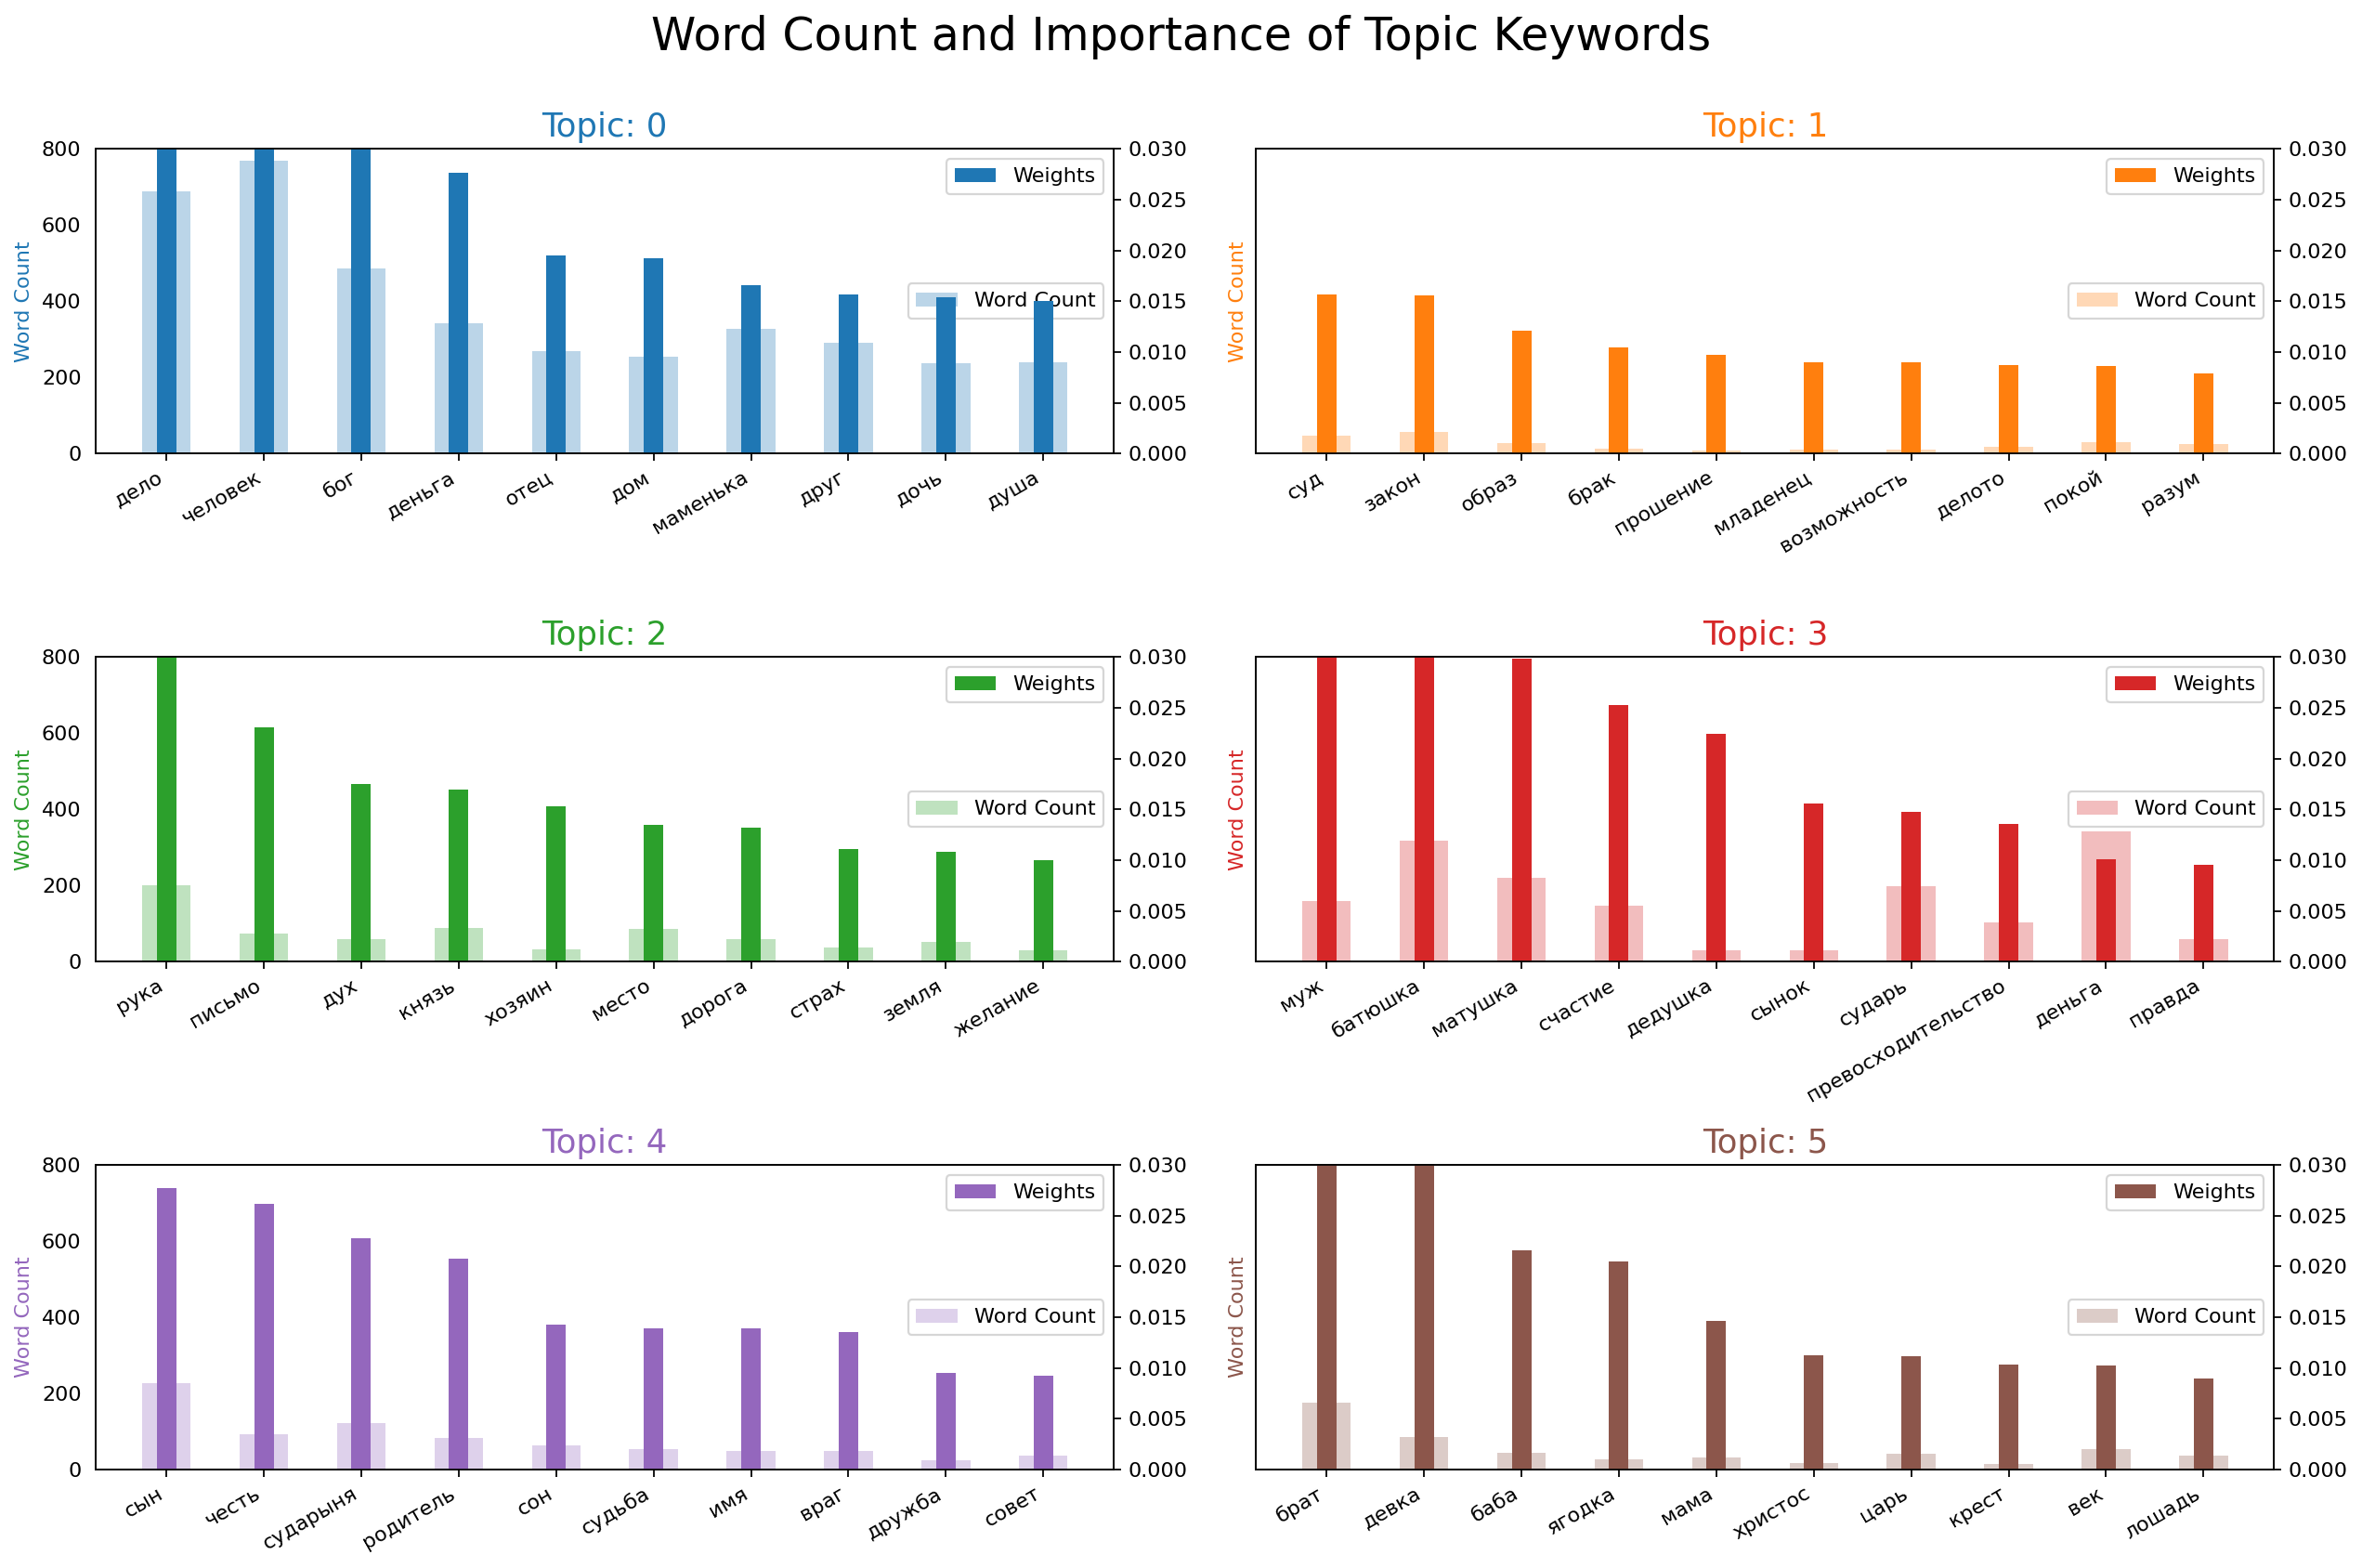

In [56]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data.clean_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 800)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='right'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [34]:
print('\nPerplexity: ', Perplexity )
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.119778687764656

Coherence Score:  0.47953183559509927


#Sklearn

## CountVectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = stopwords.words('russian')

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop_words)
doc_term_matrix = count_vect.fit_transform(data['clean_text'].apply(lambda x: ' '.join(x)).values)

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [28]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

связь
чорт
девица
посещение
купец
тётка
ода
урок
карта
среда


In [29]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [30]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['право', 'рука', 'ум', 'папенька', 'бог', 'дом', 'брат', 'человек', 'деньга', 'дело']


Top 10 words for topic #1:
['человек', 'муж', 'голова', 'батюшка', 'дело', 'жена', 'матушка', 'сударыня', 'друг', 'сударь']


Top 10 words for topic #2:
['мать', 'превосходительство', 'женщина', 'жена', 'слово', 'батюшка', 'бог', 'дело', 'человек', 'маменька']


Top 10 words for topic #3:
['жена', 'господин', 'отец', 'право', 'душа', 'дело', 'батюшка', 'бог', 'матушка', 'человек']


Top 10 words for topic #4:
['бог', 'жизнь', 'друг', 'сердце', 'любовь', 'князь', 'слово', 'дочь', 'отец', 'сын']




## TfidfVectorizer

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = tfidf_vect.fit_transform(data['clean_text'].apply(lambda x: ' '.join(x)).values)

In [32]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [57]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [58]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['душа', 'слово', 'муж', 'сударь', 'дочь', 'жена', 'дом', 'деньга', 'дело', 'человек']


Top 10 words for topic #1:
['сын', 'жена', 'ум', 'голова', 'милость', 'свет', 'сударыня', 'сударь', 'матушка', 'батюшка']


Top 10 words for topic #2:
['состояние', 'счастие', 'женщина', 'слово', 'дом', 'дело', 'беда', 'матушка', 'право', 'маменька']


Top 10 words for topic #3:
['милость', 'смерть', 'порядок', 'радость', 'свет', 'душа', 'рада', 'сердце', 'слава', 'бог']


Top 10 words for topic #4:
['государь', 'час', 'дочь', 'враг', 'родитель', 'любовь', 'князь', 'отец', 'сын', 'друг']


